# Hornsund Mass Process

In [ ]:
#Pip install packages where needed
#!pip install xarray
#!pip install hvplot
#!pip install rasterio
#!pip install rioxarray
#!pip install scikit-image
#!pip install matplotlib-scalebar
#!pip install spectral
#!pip install dask

In [1]:
# import libraries
import os  # for chdir, getcwd, path.basename, path.exists
import hvplot.xarray
import pandas as pd # for DatetimeIndex 
import rioxarray
import numpy as np #for log10, mean, percentile, power
import rasterio as rio
import imageio.v3 as iio
import cv2
from PIL import Image
import dask.array as da
import seaborn as sns
import matplotlib.image as mpimg
from rasterio.plot import show # plotting raster data
from rasterio.plot import show_hist #histograms of raster data

import glob # for listing files in tiff conversion function
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.pyplot as plt # for add_subplot, axis, figure, imshow, legend, plot, set_axis_off, set_data,
                                # set_title, set_xlabel, set_ylabel, set_ylim, subplots, title, twinx
from pathlib import Path    
from skimage.filters.rank import entropy #for GLCM entropy
from skimage.util import img_as_ubyte #Avoid precision loss converting image of type float32 to uint8 as required by rank filters
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from skimage.morphology import disk #manage disk while running
from sklearn.cluster import KMeans
from spectral import *
import spectral.io.envi as envi #run PCA

In [580]:
filename = 'C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/ALL_SAT/composite/RS2/3band_clipped/RS2_SCNA_20120724_153517_ASC_058_einc_3e892f85_526a_4f39_a25d_676095c9f668.tif'
src = rio.open(filename)

n_bands = src.meta['count']
img_shape = src.shape

band_numbers = ['1', '2', '3']
pc_names = ['PC1', 'PC2', 'PC3']

band_names = ['HH','HV','theta']

In [581]:
stats_raw = []

for idx, band in enumerate(src.read()):

    stats_raw.append({
        'band': idx + 1,
        'min': band.min(),
        'mean': band.mean(),
        'median': np.median(band),
        'max': band.max(),
        'std': int(np.std(band)),
        'var': int(np.var(band)),
        'vmin': int(band.mean() - np.std(band)),
        'vmax': int(band.mean() + np.std(band)),

    })

summary_stats = pd.DataFrame.from_records(
    stats_raw, index='band').astype(int)

summary_stats

min  mean  median  max  std  var  vmin  vmax
band                                              
1       0    12       0   32   15  229    -2    27
2     -31     0       9    9   10  114   -10    11
3     -36    -5       9    9   17  312   -23    11

In [582]:
fig = plt.figure(figsize=(8,8))
cmap = plt.get_cmap('inferno_r')

ax1 = plt.subplot2grid((1,3), (0,0))
ax2 = plt.subplot2grid((1,3), (0,1))
ax3 = plt.subplot2grid((1,3), (0,2))

b1 = ax1.imshow(src.read()[0],cmap=cmap, vmin=stats_raw[0]['min'], vmax=stats_raw[0]['max'])
b2 = ax2.imshow(src.read()[1], cmap=cmap, vmin=stats_raw[1]['min'], vmax=stats_raw[1]['max'])
b3 = ax3.imshow(src.read()[2], cmap=cmap, vmin=stats_raw[2]['min'], vmax=stats_raw[2]['max']) 

fig.colorbar(b1, ax=ax1, label='degrees (°)', orientation='horizontal')
fig.colorbar(b2, ax=ax2, label='decibels (db)', orientation='horizontal')
fig.colorbar(b3, ax=ax3, label='decibels (db)', orientation='horizontal')

ax1.set_title('THETA')
ax2.set_title('HH')
ax3.set_title('HV')

plt.tight_layout()
#plt.savefig('path/img.png',dpi=1500,     #resoluton  
#            bbox_inches='tight',  # Tight layout
#            pad_inches=0.1,       # Padding
#            facecolor='white',    # Background color
#            edgecolor='none',     # Edge color
#            format='png')
plt.show()

In [583]:
bnd_list = []
for i in range(n_bands):
    bnd = da.from_array(src.read(i+1))
    bnd_list.append(bnd)

dask_band_stack = da.dstack(bnd_list)
dask_band_stack = dask_band_stack.rechunk('auto')
src_sr = dask_band_stack.compute()

In [584]:
flat_bnds = np.zeros((src_sr[:, :, 0].size, n_bands))

for i in range(n_bands):
    bnd_i = src_sr[:, :, i].flatten()
    bnd_norm = 1024*((bnd_i - bnd_i.min())/(bnd_i.max() - bnd_i.min()))
    flat_bnds[:, i] = bnd_norm

In [585]:
cor_lists = np.corrcoef(flat_bnds.transpose())

cor_data = pd.DataFrame(
    cor_lists,
    columns=band_numbers,
    index=band_numbers,
)

cor_data = round(cor_data, 2)

In [586]:
EigVal_cor, EigVec_cor = np.linalg.eig(cor_lists)

std_eigVec_table = pd.DataFrame(
    EigVec_cor,
    columns=band_numbers,
    index=band_numbers
)

std_eigVec_table = round(std_eigVec_table, 3)

In [587]:
order2 = EigVal_cor.argsort()[::-1]

EigVal_cor = EigVal_cor[order2]

In [588]:
pc_values_cor = (EigVal_cor/sum(EigVal_cor)*100).round(2)

In [589]:
value = sum(pc_values_cor[0:3])

In [590]:
loading_cor = pd.DataFrame(
    EigVec_cor * np.sqrt(EigVal_cor) / np.sqrt(np.abs(cor_lists)),
    columns=pc_names,
    index=band_names,
    )

loading_cor = round(loading_cor, 3)

In [591]:
PC_std = np.matmul(flat_bnds, EigVec_cor) 

In [592]:
stats_std_PC = []
for i in range(n_bands):
    band = PC_std[:, i]

    stats_std_PC.append({
        'band': i + 1,
        'min': band.min(),
        'mean': band.mean(),
        'max': band.max(),
        'std': int(np.std(band)),
        'var': int(np.var(band)),
    })

smry_std_PC = pd.DataFrame.from_records(
    stats_std_PC, index='band').astype(int)

In [593]:
PC_std_2d = np.zeros((img_shape[0], img_shape[1], n_bands))
for i in range(n_bands):
    PC_std_2d[:, :, i] = PC_std[:, i].reshape(-1, img_shape[1])

In [594]:
PC_nrm = np.zeros(PC_std.shape)

for i in range(n_bands):
    PC_i = PC_std[:, i]
    pc_norm_mm = 1024*(PC_i - PC_i.min())/(PC_i.max() - PC_i.min())
    PC_nrm[:, i] = pc_norm_mm

PC_std_2d_norm = np.zeros((img_shape[0], img_shape[1], n_bands))
for i in range(n_bands):
    PC_std_2d_norm[:, :, i] = PC_nrm[:, i].reshape(-1, img_shape[1])


In [595]:
# 3 dimensional dummy array with zeros
MB_img = da.zeros((img_shape[0], img_shape[1], n_bands))

# stacking up images into the array
for i in range(n_bands):
    # MB_img[:,:,i] = cv2.imread('band'+str(i+1)+'.jpg', cv2.IMREAD_GRAYSCALE)  
    MB_img[:,:,i] = src.read(i+1)

# Convert 2d band array in 1-d to make them as feature vectors and Standardization
MB_matrix = da.zeros((MB_img[:,:,0].size,n_bands))

for i in range(n_bands):
    MB_array = MB_img[:,:,i].flatten()  # covert 2d to 1d array 
    MB_arrayStd = (MB_array - MB_array.mean())/MB_array.std()  
    MB_matrix[:,i] = MB_arrayStd

# MB_matrix.shape
MB_matrix.compute()

array([[ 1.154, -1.128, -1.131],
       [ 1.154, -1.085, -1.163],
       [ 1.154, -0.982, -1.108],
       ...,
       [-0.837,  0.802,  0.835],
       [-0.837,  0.802,  0.835],
       [-0.837,  0.802,  0.835]], shape=(505461, 3))

In [596]:
# Covariance
np.set_printoptions(precision=3)
cov = np.cov(MB_matrix.transpose())

# Eigen Values
EigVal,EigVec = np.linalg.eig(cov)

C:\Users\jullian.williams\.conda\envs\pyproj_env\Lib\site-packages\dask\array\core.py:1739: FutureWarning: The `numpy.linalg.eig` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


In [597]:
# Ordering Eigen values and vectors
order = EigVal.argsort()[::-1]
EigVal = EigVal[order]
EigVec = EigVec[:,order]

#Projecting data on Eigen vector directions resulting to Principal Components 
PC = np.matmul(MB_matrix,EigVec)   #cross product
PC.compute()

array([[-1.970e+00, -2.954e-03,  1.799e-02],
       [-1.965e+00, -4.992e-02, -9.159e-03],
       [-1.874e+00, -1.148e-01,  2.479e-02],
       ...,
       [ 1.429e+00,  2.106e-02, -9.628e-04],
       [ 1.429e+00,  2.106e-02, -9.628e-04],
       [ 1.429e+00,  2.106e-02, -9.628e-04]], shape=(505461, 3))

In [598]:
kwargs = src.meta
kwargs.update(
    dtype=rio.float32,
    count=3)

In [599]:
# band, row, col
tmp_std_norm = np.moveaxis(PC_std_2d_norm, [0, 1, 2], [2, 1, 0])
PC_img_std_norm = np.swapaxes(tmp_std_norm, 1, 2)

In [600]:
with rio.open('C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/ALL_SAT/composite/classed/RS_multi/npy/PCimg/PC_RS2_SCNA_20120724_153517_ASC_058_einc_3e892f85_526a_4f39_a25d_676095c9f668.tif', 'w', **kwargs) as dst:
    dst.write(PC_img_std_norm.astype(rio.float32))

In [601]:
filename = 'C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/ALL_SAT/composite/classed/RS_multi/npy/PCimg/PC_RS2_SCNA_20120724_153517_ASC_058_einc_3e892f85_526a_4f39_a25d_676095c9f668.tif'
image = iio.imread(filename)

In [602]:
np.save('C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/ALL_SAT/composite/classed/RS_multi/npy/PC_RS2_SCNA_20120724_153517_ASC_058_.npy', image)

In [197]:
#Check to see it's there correctly
image_data = np.load('C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/ALL_SAT/composite/classed/RS_multi/npy/PC_RS2_SCNA_20120426_153112_ASC_158_.npy')
print(image_data.shape)

(561, 864, 3)


#### Loop classification technique

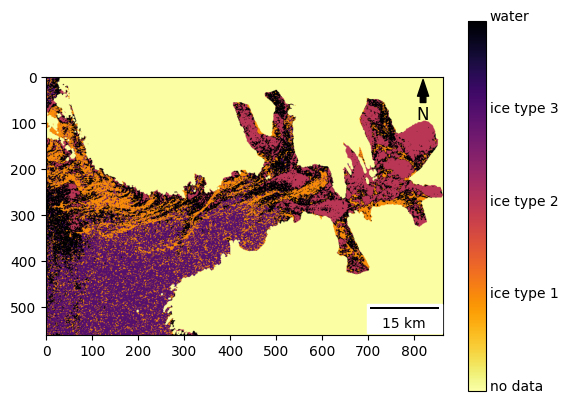

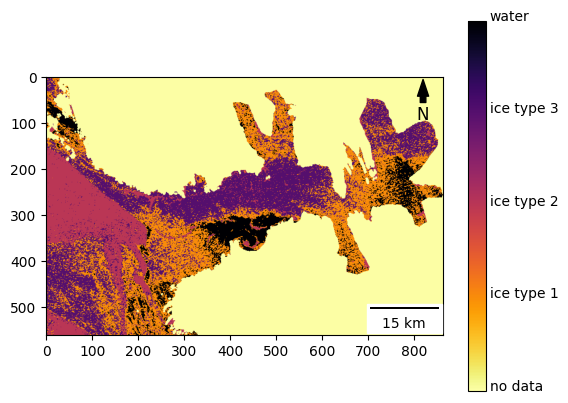

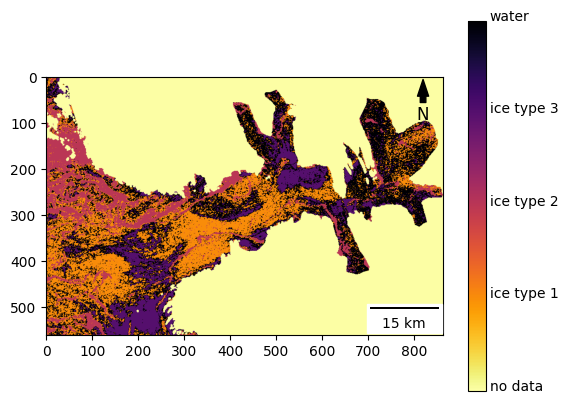

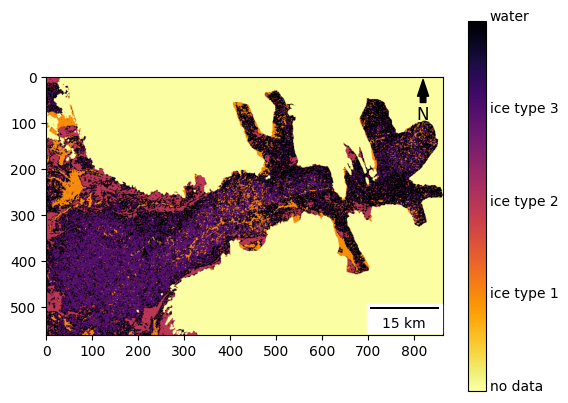

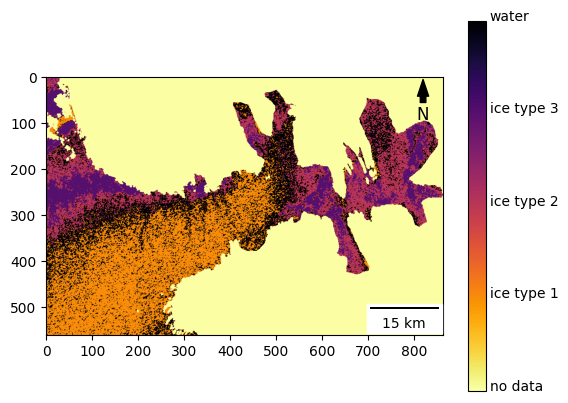

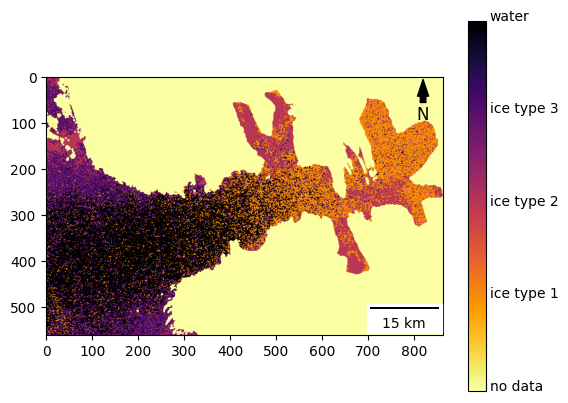

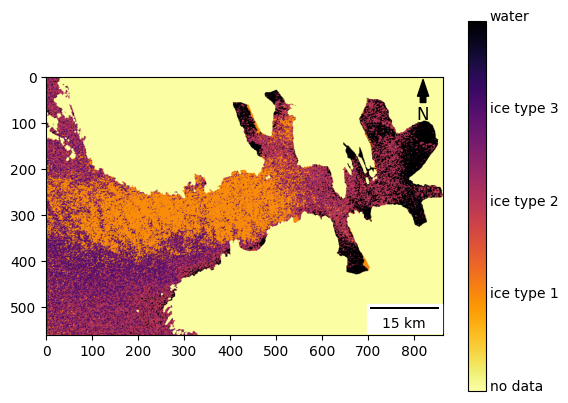

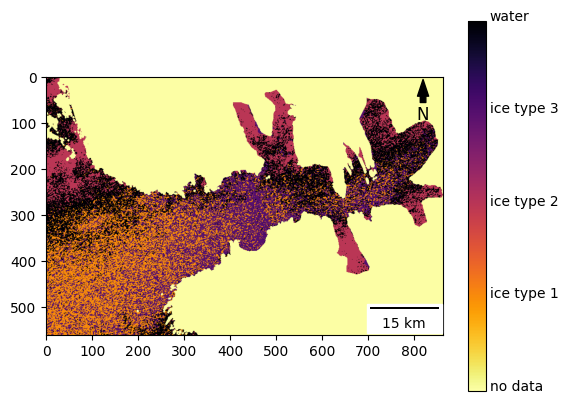

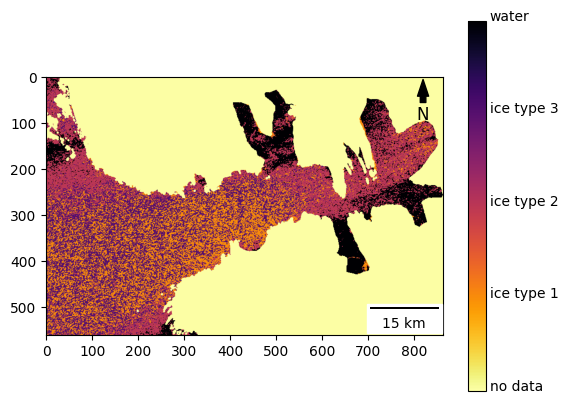

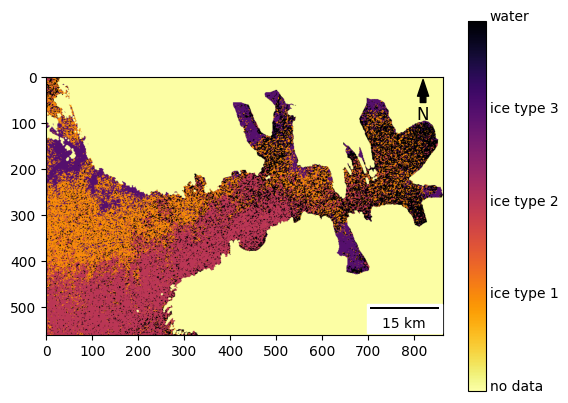

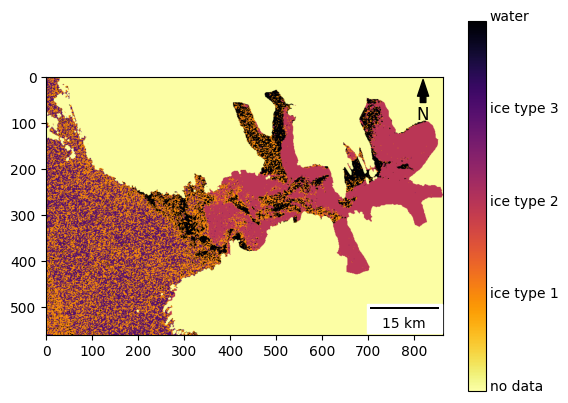

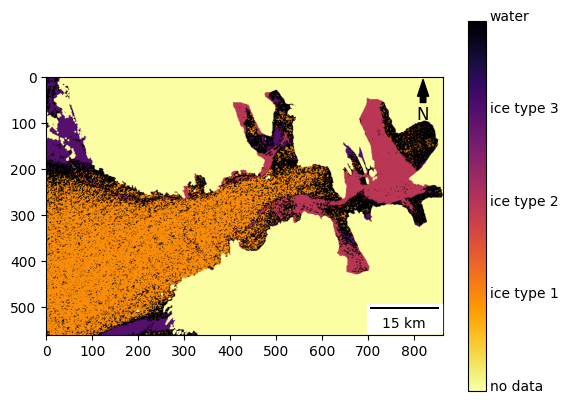

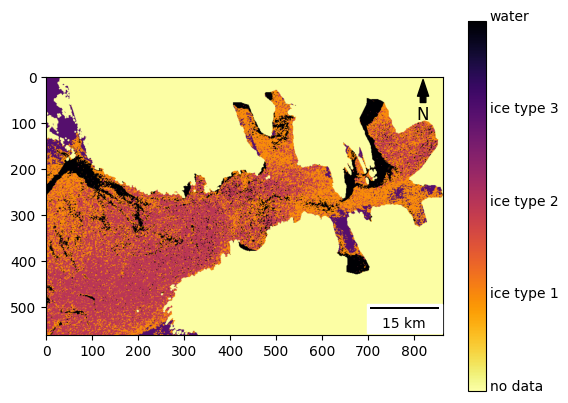

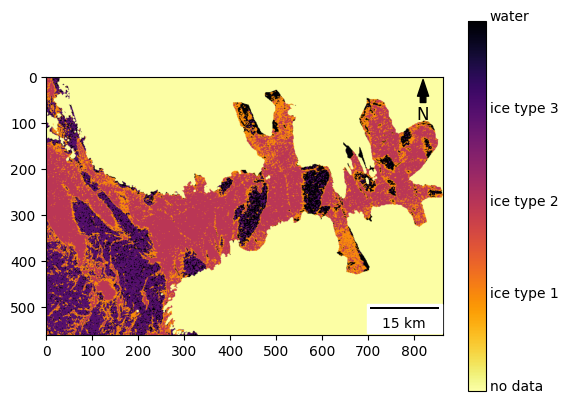

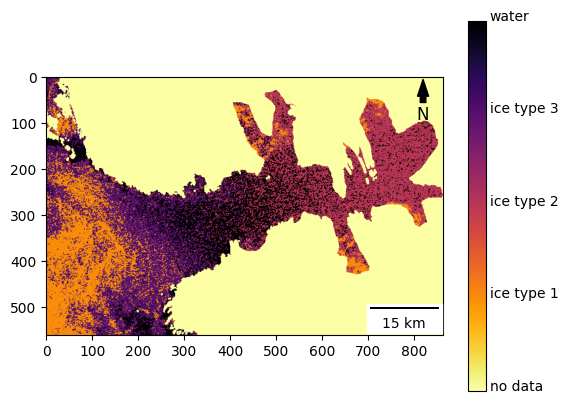

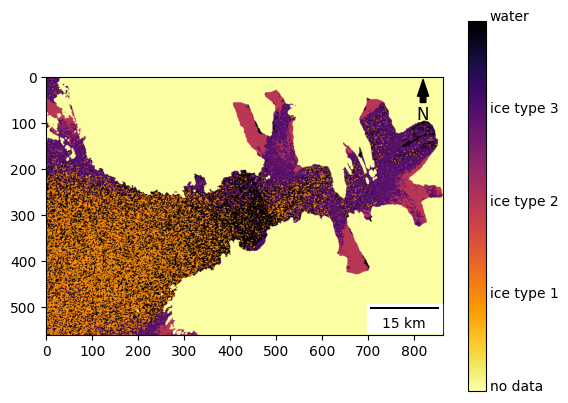

In [9]:
input_dir = "C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/ALL_SAT/composite/classed/RS_multi/npy/"
output_dir = "C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/ALL_SAT/composite/classed/RS_multi/PCA_classed/kmeans/"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Loop through all .tif files in the input directory
for subdir, _, files in os.walk(input_dir):
    for filename in files: 
        # Check if the file is an image (e.g., .jpg, .png)
        if filename.endswith(('.npy')):
            input_path = os.path.join(subdir, filename)
            output_path = os.path.join(output_dir, filename.replace(".npy", ".png"))

            image_data = np.load(input_path)
            image_data_2d = image_data.reshape(-1, image_data.shape[-1] )

            # Initialize the PCA model with 3 components
            pca = PCA(n_components=3)
            
            # Fit the model to the image data
            pca.fit(image_data_2d)
            
            # Transform the data into the PCA space
            pca_results = pca.transform(image_data_2d)

            # # Define the number of clusters
            n_clusters = 5
            
            # Initialize the k-means model
            kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto')
            
            # Fit the model to the data
            kmeans.fit(pca_results)
            
            # Predict the cluster assignments for each pixel
            labels = kmeans.predict(pca_results)

            fig, ax = plt.subplots()
            # Reshape the labels back into the original image shape
            labels = labels.reshape(image_data.shape[0], image_data.shape[1])
            plt.imshow(labels, cmap='inferno_r')
            
            cbar = plt.colorbar(cmap='inferno_r')
            cbar.ax.get_yaxis().set_ticks([])
            for j, lab in enumerate(['no data','ice type 1','ice type 2','ice type 3','water']):
                cbar.ax.text(1.2, (8 * j + 1) / 8.0, lab, ha='left', va='top')


            x, y, arrow_length = 0.95, 0.99, 0.1                        #left-right, up-down,line length
            ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=4, headwidth=8),
            ha='center', va='top', fontsize=12,
            xycoords=ax.transAxes)

            scalebar = ScaleBar(100, units="m", location='lower right')  # 0.5 units per pixel
            ax.add_artist(scalebar)

            #plt.savefig(output_path, dpi=1500, bbox_inches='tight',pad_inches=0.1,facecolor='white',edgecolor='none',format='png')

            plt.show()

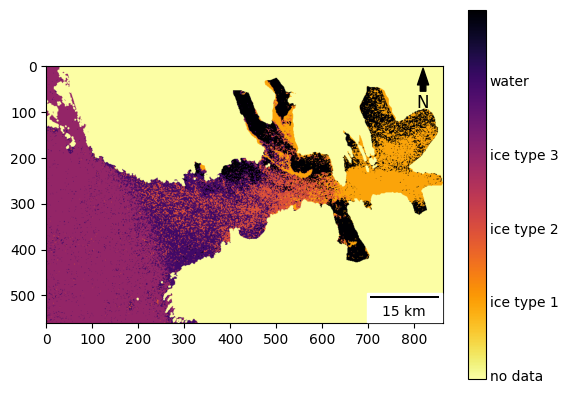

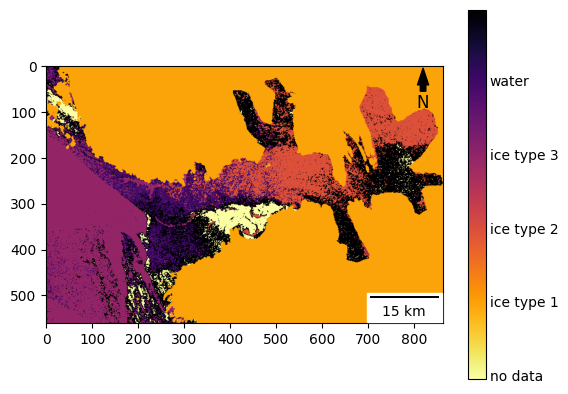

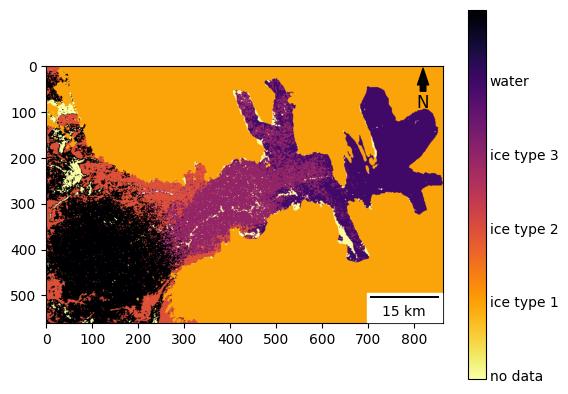

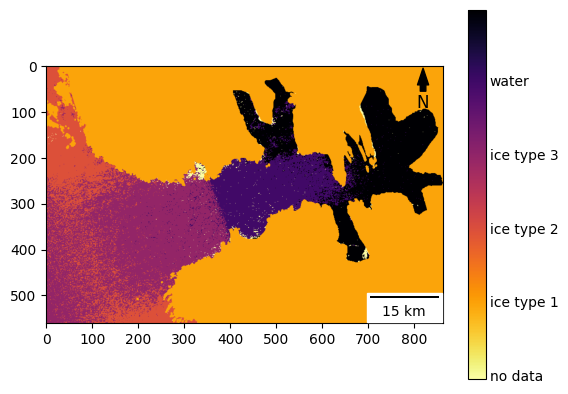

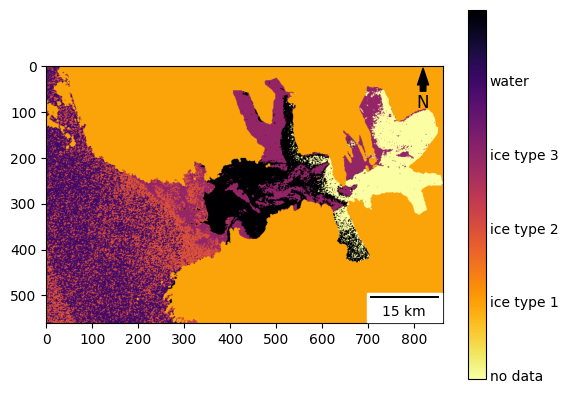

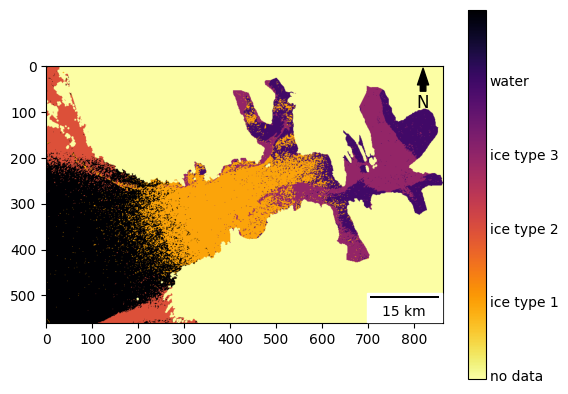

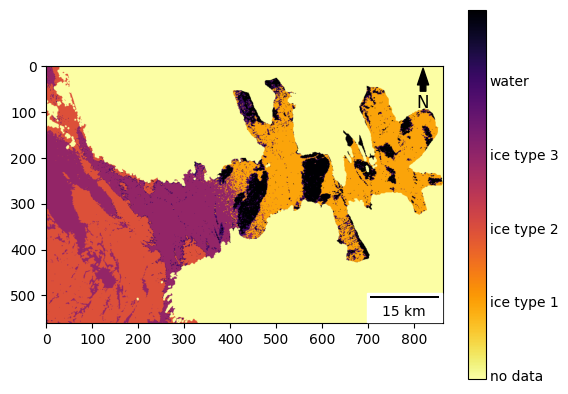

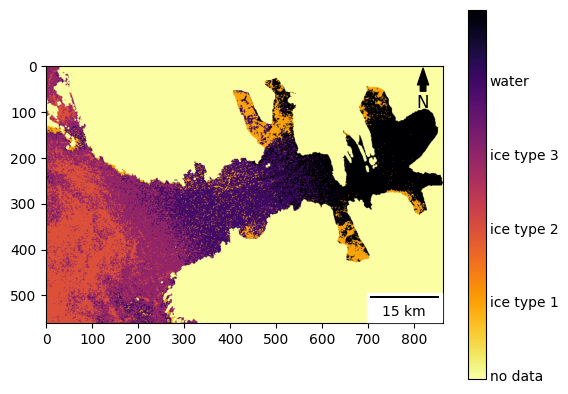

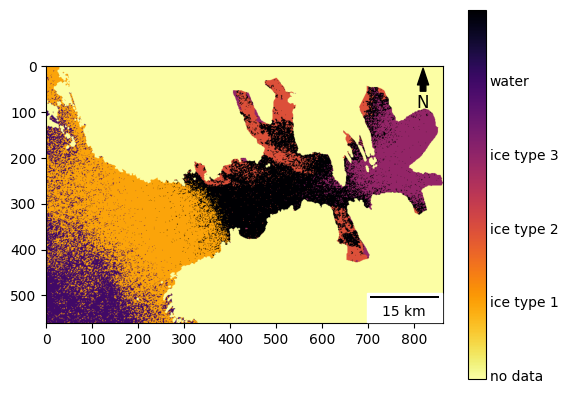

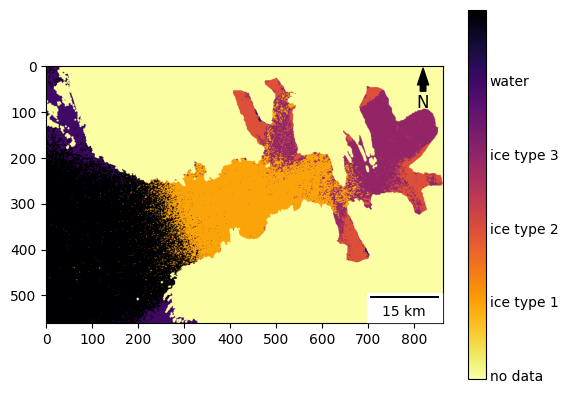

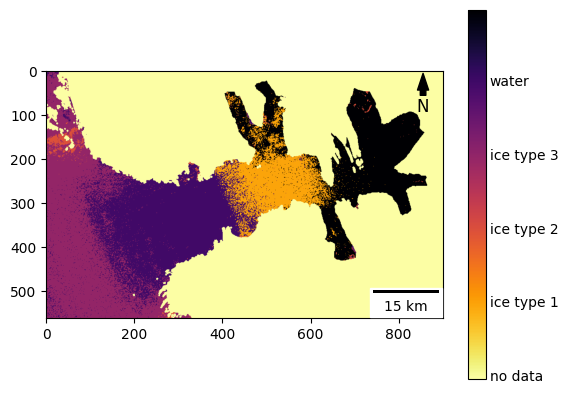

In [11]:
input_dir = "C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/ALL_SAT/composite/classed/RS_multi/npy/"
output_dir = "C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/ALL_SAT/composite/classed/RS_multi/PCA_classed/gaussian/"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Loop through all .tif files in the input directory
for subdir, _, files in os.walk(input_dir):
    for filename in files: 
        # Check if the file is an image (e.g., .jpg, .png)
        if filename.endswith(('.npy')):
            input_path = os.path.join(subdir, filename)
            output_path = os.path.join(output_dir, filename.replace(".npy", ".png"))

            image_data = np.load(input_path)
            image_data_2d = image_data.reshape(-1, image_data.shape[-1] )

            # Initialize the PCA model with 3 components
            pca = PCA(n_components=3)
            
            # Fit the model to the image data
            pca.fit(image_data_2d)
            
            # Transform the data into the PCA space
            pca_results = pca.transform(image_data_2d)

            # # Define the number of clusters

            n_clusters = 6
            gmm_model = GaussianMixture(n_components=n_clusters)
            gmm_model.fit(pca_results)

            cluster_labels = gmm_model.predict(pca_results)
            # Reshape the labels back into the original image shape
            cluster_labels = cluster_labels.reshape(image_data.shape[0], image_data.shape[1])

            fig, ax = plt.subplots()

            plt.imshow(cluster_labels, cmap='inferno_r')

            x, y, arrow_length = 0.95, 0.99, 0.1                  #left-right, up-down,line length
            ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=4, headwidth=8),
            ha='center', va='top', fontsize=12,
            xycoords=ax.transAxes)
            
            cbar = plt.colorbar(cmap='inferno_r')
            cbar.ax.get_yaxis().set_ticks([])
            for j, lab in enumerate(['no data','ice type 1','ice type 2','ice type 3','water']):
                cbar.ax.text(1.2, (8 * j + 1) / 8.0, lab, ha='left', va='top')
            
            scalebar = ScaleBar(100, units="m", location='lower right')  # 0.5 units per pixel
            ax.add_artist(scalebar)
            
            #plt.savefig(output_path, dpi=1500, bbox_inches='tight',pad_inches=0.1,facecolor='white',edgecolor='none',format='png')
            
            plt.show()

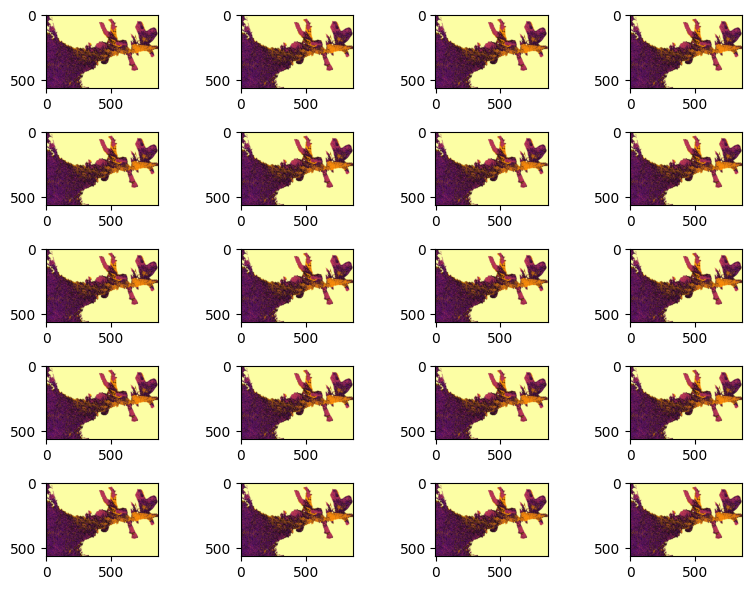

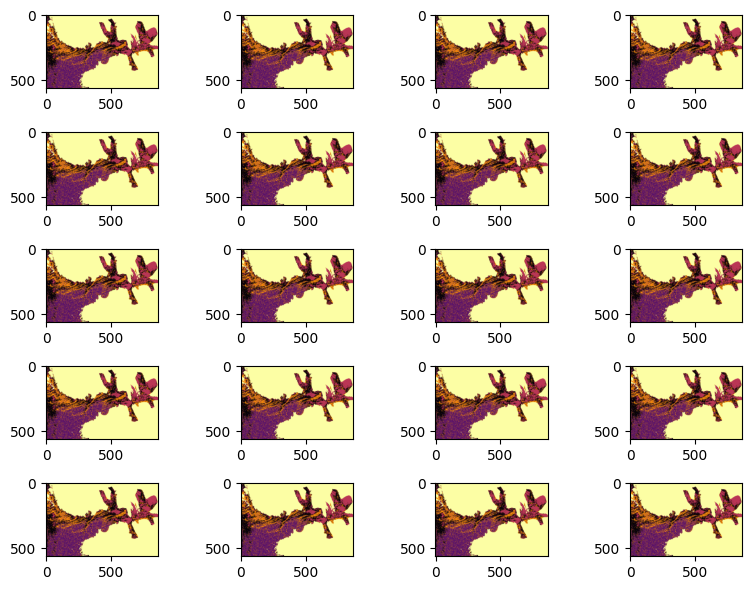

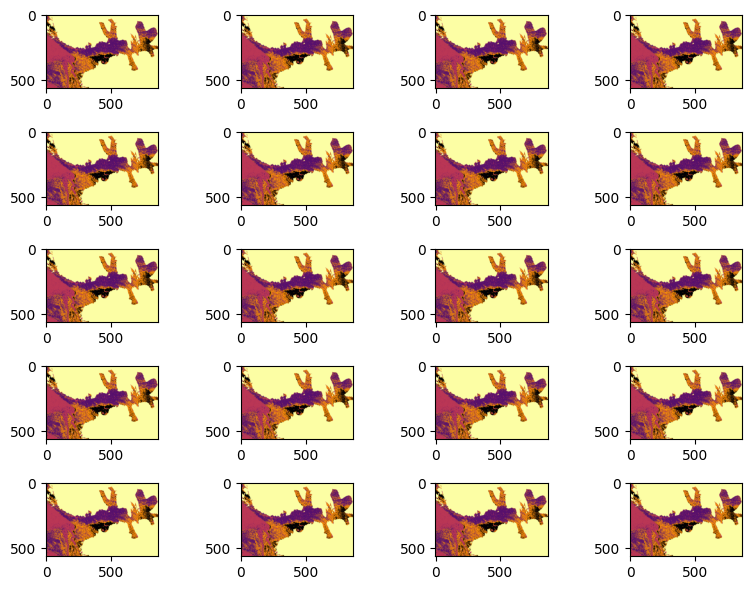

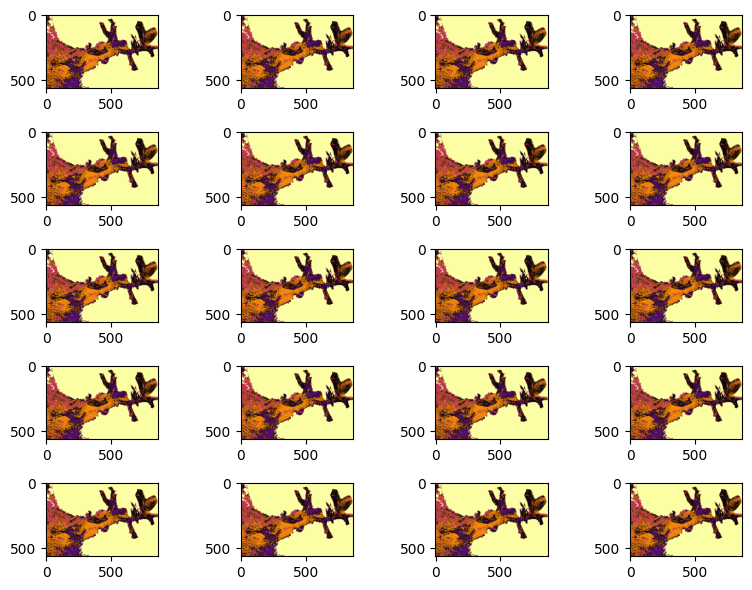

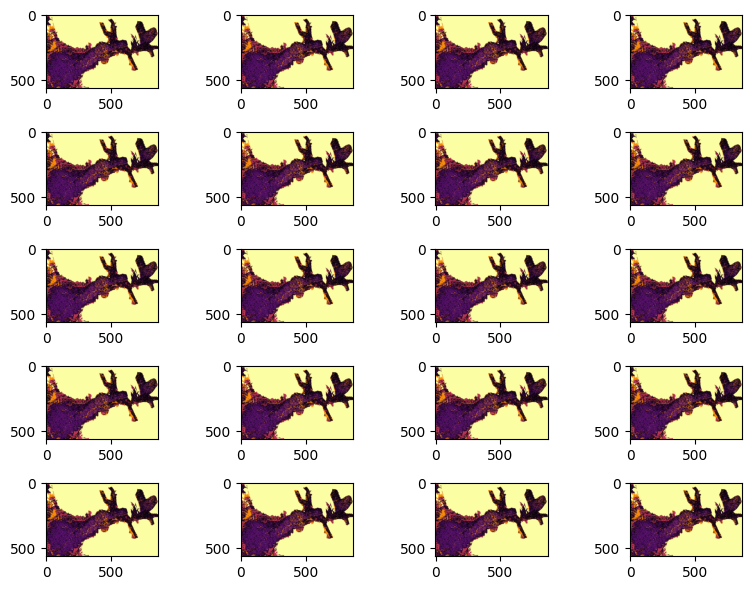

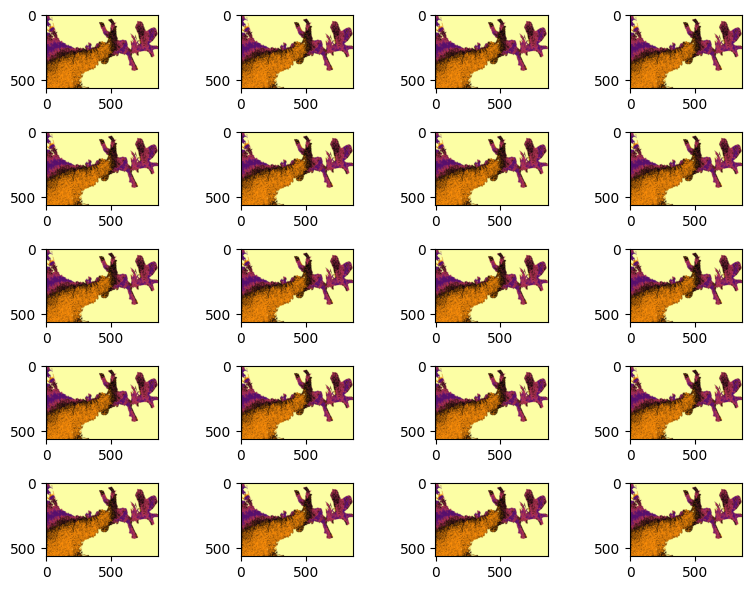

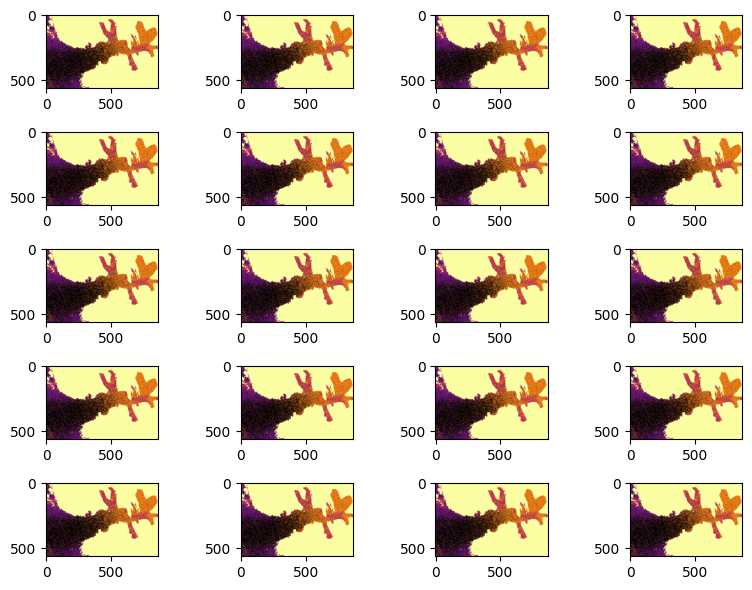

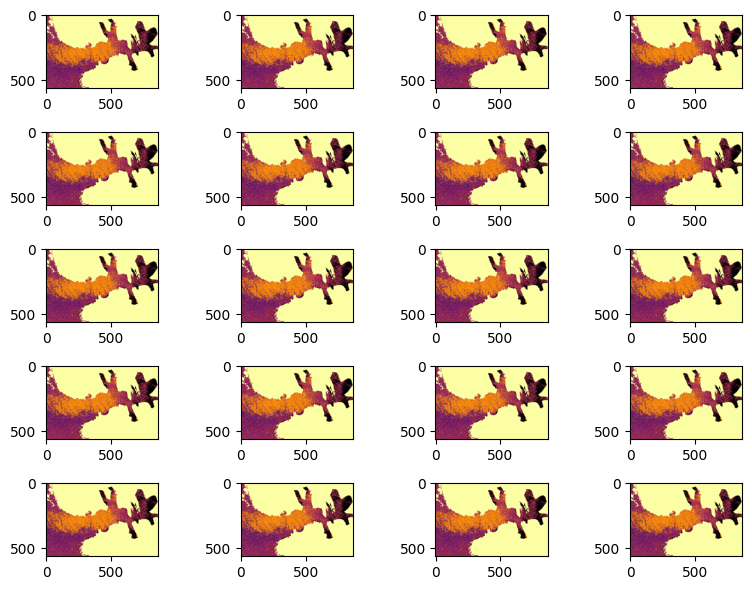

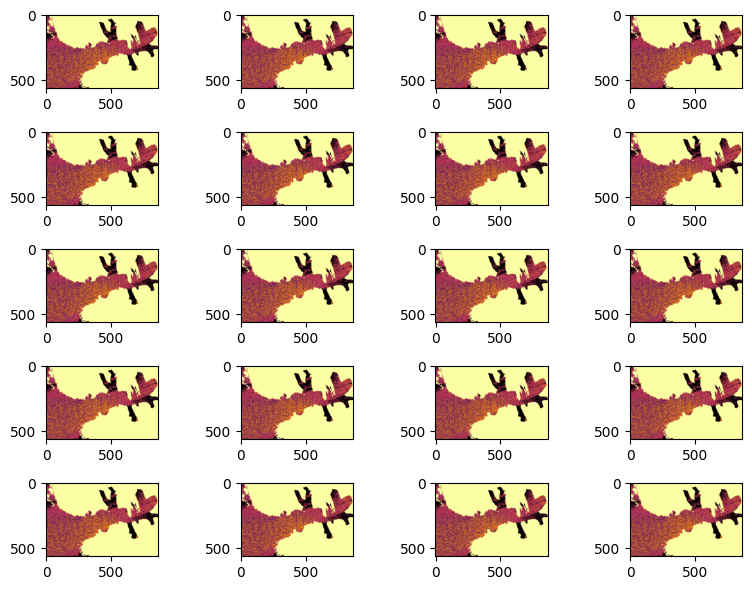

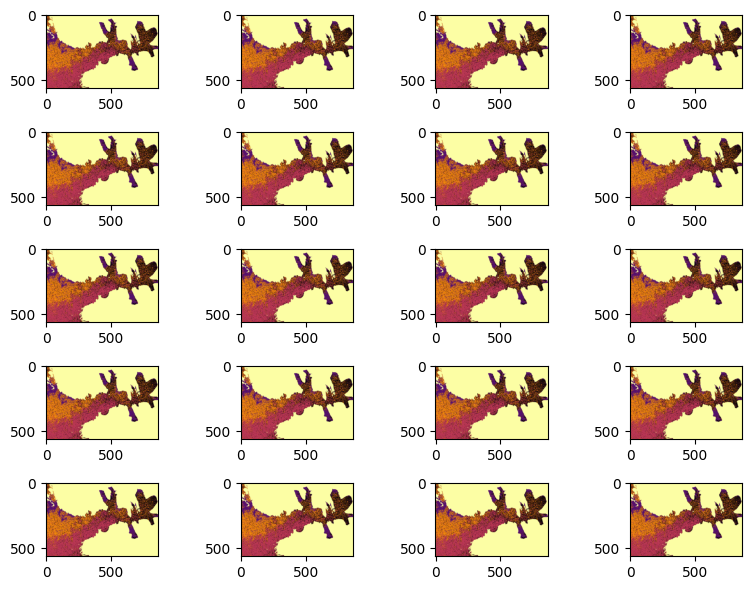

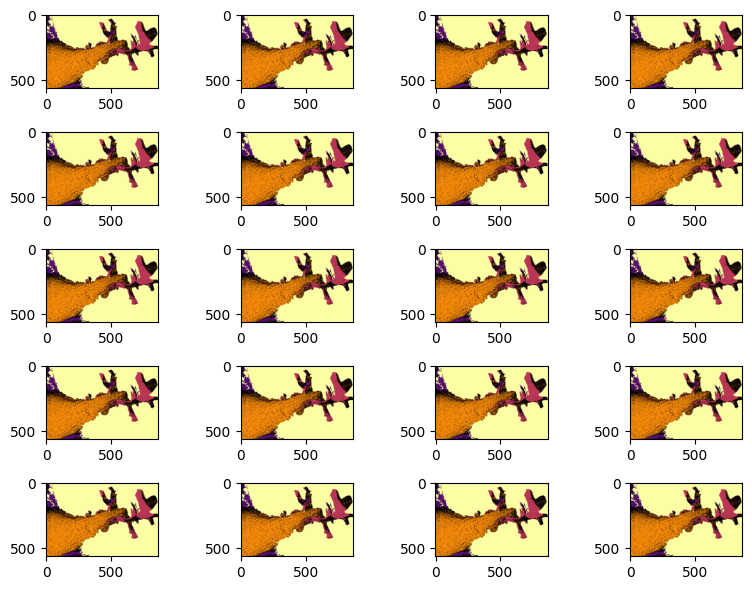

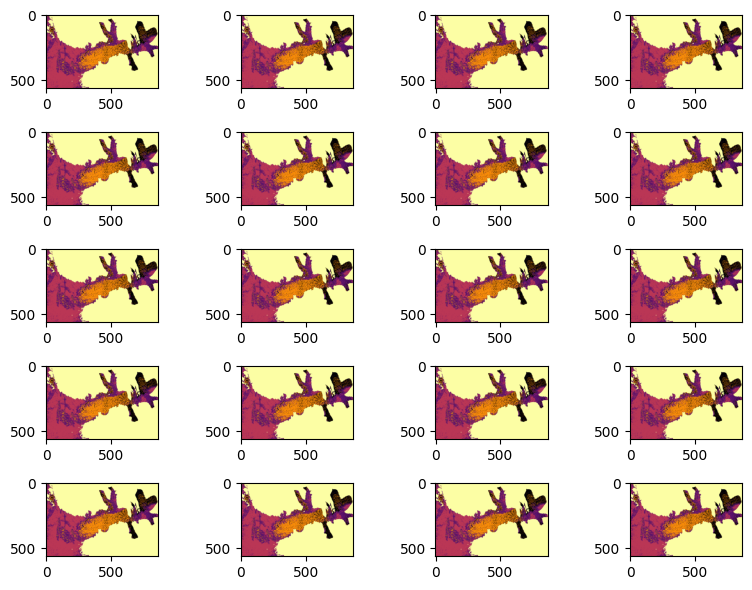

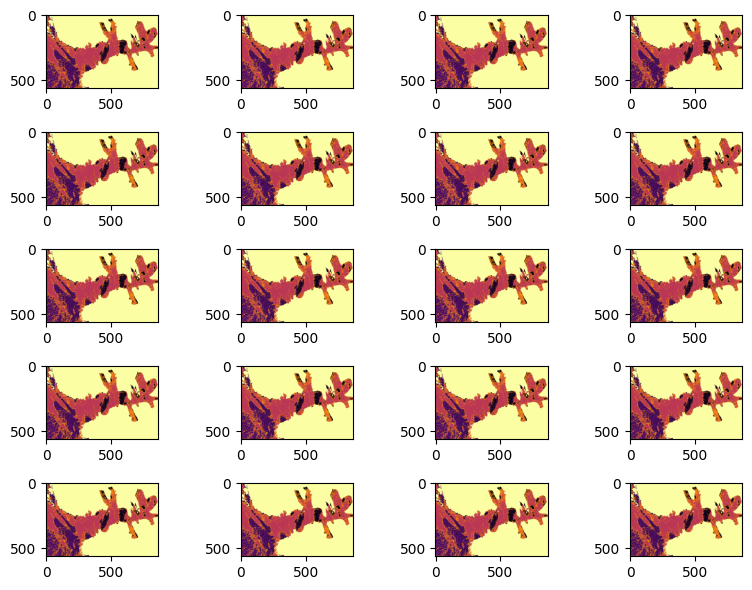

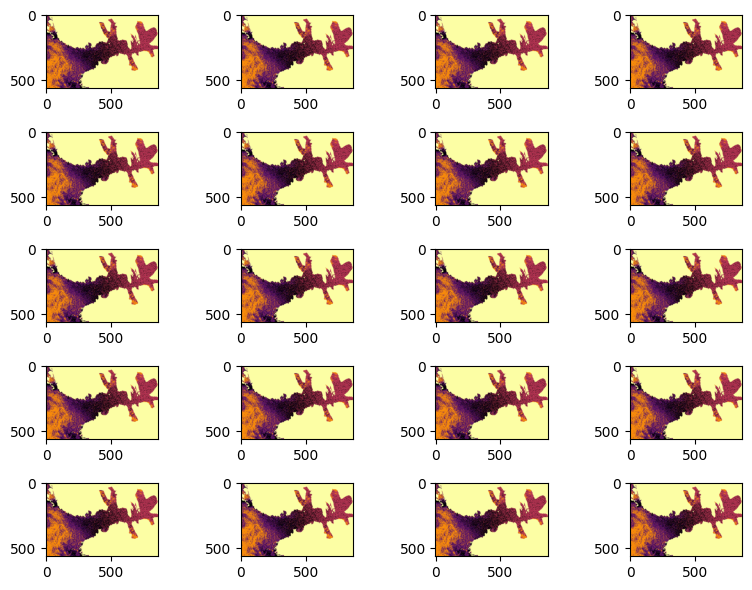

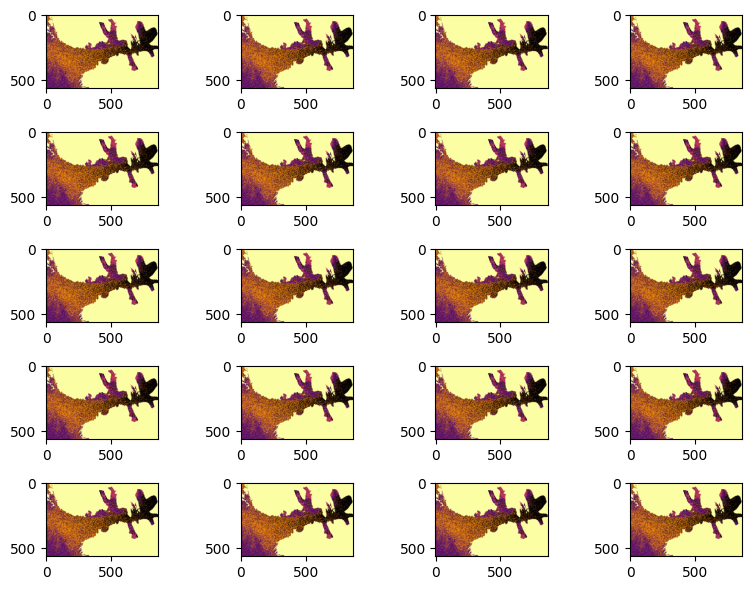

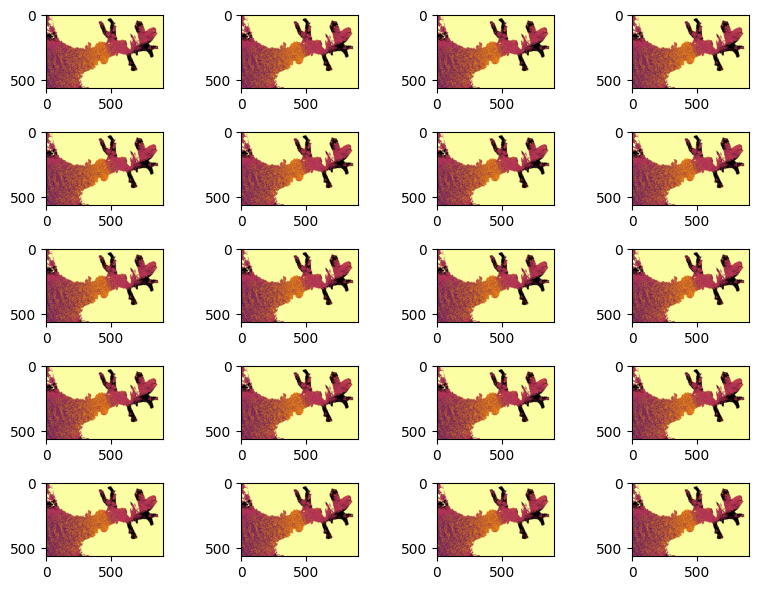

In [27]:
input_dir = "C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/ALL_SAT/composite/classed/RS_multi/npy/"

# Ensure output directory exists
#os.makedirs(output_dir, exist_ok=True)

# Loop through all .tif files in the input directory
for subdir, _, files in os.walk(input_dir):
    for filename in files: 
        # Check if the file is an image (e.g., .jpg, .png)
        if filename.endswith(('.npy')):
            input_path = os.path.join(subdir, filename)
            #output_path = os.path.join(output_dir, filename.replace(".npy", ".png"))

            image_data = np.load(input_path)
            image_data_2d = image_data.reshape(-1, image_data.shape[-1] )

            # Initialize the PCA model with 3 components
            pca = PCA(n_components=3)
            
            # Fit the model to the image data
            pca.fit(image_data_2d)
            
            # Transform the data into the PCA space
            pca_results = pca.transform(image_data_2d)

            # # Define the number of clusters
            n_clusters = 5
            
            # Initialize the k-means model
            kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto')
            
            # Fit the model to the data
            kmeans.fit(pca_results)
            
            # Predict the cluster assignments for each pixel
            labels = kmeans.predict(pca_results)
            
            # Reshape the labels back into the original image shape
            labels = labels.reshape(image_data.shape[0], image_data.shape[1])

            # Create a figure and subplots
            fig, axes = plt.subplots(5,4, figsize=(8, 6))  # 2x2 grid of subplots
                        
            # Flatten the axes array for easy iteration
            axes = axes.ravel() #Or axes.flatten()
                        
            for a in axes:
                a.imshow(labels, cmap='inferno_r')
                                    
            # Adjust layout to prevent overlap
            plt.tight_layout() 
            plt.show()
        


In [28]:
print(type(labels


<class 'numpy.ndarray'>


In [ ]:
            # Create a figure and subplots
fig, axes = plt.subplots(5,4, figsize=(8, 6))  # 2x2 grid of subplots
            
            # Flatten the axes array for easy iteration
axes = axes.flatten()
            
for a in axes:
    a.imshow(labels, cmap='inferno_r')
            
            # Adjust layout to prevent overlap
plt.tight_layout()
plt.show()